In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
# Check if the directory exists
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/dataset"
if not os.path.exists(dataset_dir):
  os.makedirs(dataset_dir)
  print(f"Directory '{dataset_dir}' created successfully.")

!unzip /content/drive/MyDrive/Colab\ Notebooks/521153S-3005-final-project.zip -d /content/drive/MyDrive/Colab\ Notebooks/dataset

Archive:  /content/drive/MyDrive/Colab Notebooks/521153S-3005-final-project.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/sample_submission.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/347/347_l1.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/347/347_l2.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/347/347_r1.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/347/347_r2.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/353/353_l1.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/35


Epoch 1/10
Training: 100%|██████████| 50/50 [05:13<00:00,  6.27s/batch, Loss=1.0277]
Train Loss: 1.3218, Train Kappa: 0.5089
Validation Kappa: 0.6761

Epoch 2/10
Training: 100%|██████████| 50/50 [04:54<00:00,  5.90s/batch, Loss=0.9324]
Train Loss: 1.0561, Train Kappa: 0.6800
Validation Kappa: 0.7323

Epoch 3/10
Training: 100%|██████████| 50/50 [05:02<00:00,  6.05s/batch, Loss=0.9441]
Train Loss: 0.8922, Train Kappa: 0.7839
Validation Kappa: 0.6862

Epoch 4/10
Training: 100%|██████████| 50/50 [05:02<00:00,  6.05s/batch, Loss=0.7448]
Train Loss: 0.8362, Train Kappa: 0.8005
Validation Kappa: 0.6846

Epoch 5/10
Training: 100%|██████████| 50/50 [05:04<00:00,  6.08s/batch, Loss=0.7476]
Train Loss: 0.7386, Train Kappa: 0.8098
Validation Kappa: 0.7583

Epoch 6/10
Training: 100%|██████████| 50/50 [04:57<00:00,  5.96s/batch, Loss=0.4452]
Train Loss: 0.6625, Train Kappa: 0.8509
Validation Kappa: 0.6980

Epoch 7/10
Training: 100%|██████████| 50/50 [05:06<00:00,  6.12s/batch, Loss=0.5879]
Train Lo

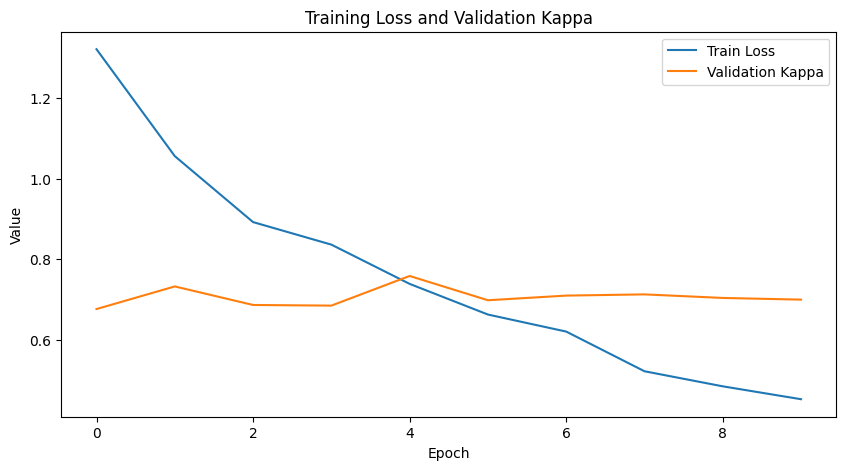

<ipython-input-5-f06b391dce30>:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_name}_best_model.pth'))


Predictions saved to ./test_predictions.csv


AttributeError: 'EfficientNet' object has no attribute 'layer4'

In [ ]:
import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

# Hyper Parameters
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 10

# Define Model Loading Logic
def load_model(model_name, num_classes=5):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "resnet34":
        model = models.resnet34(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    elif model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} not supported.")
    return model

# Dataset Definition
class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform
        self.test = test
        self.mode = mode
        self.data = self.load_data()

    def load_data(self):
        df = pd.read_csv(self.ann_file)
        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

# Transformations
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training Function
def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25, checkpoint_path='model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0
    history = {"train_loss": [], "val_kappa": []}

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit='batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        train_loss = sum(running_loss) / len(running_loss)
        train_kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        print(f'Train Loss: {train_loss:.4f}, Train Kappa: {train_kappa:.4f}')

        # Validate
        val_kappa = validate_model(model, val_loader, device)
        history["train_loss"].append(train_loss)
        history["val_kappa"].append(val_kappa)
        print(f'Validation Kappa: {val_kappa:.4f}')

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'Best Validation Kappa: {best_val_kappa:.4f} at Epoch {best_epoch}')

    # Plot Training History
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_kappa"], label="Validation Kappa")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Training Loss and Validation Kappa")
    plt.legend()
    plt.show()

    return model

# Validation Function
def validate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return cohen_kappa_score(all_labels, all_preds, weights='quadratic')

# Test Evaluation Function
def evaluate_test_data(model, test_loader, device):
    model.eval()
    all_preds = []
    all_image_ids = []
    with torch.no_grad():
        for i, images in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            # Collect image IDs for submission
            image_ids = [f"Image_{i * test_loader.batch_size + j}" for j in range(images.size(0))]
            all_image_ids.extend(image_ids)
    # Save predictions to CSV
    submission_df = pd.DataFrame({"ID": all_image_ids, "Target": all_preds})
    submission_df.to_csv("./content/drive/MyDrive/Colab Notebooks/dataset/Dual_test_predictions.csv", index=False)
    print("Predictions saved to ./Dual_test_predictions.csv")

# Grad-CAM Implementation
def generate_gradcam(model, image, target_layer, device):
    model.eval()
    image = image.unsqueeze(0).to(device)

    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle1 = target_layer.register_forward_hook(forward_hook)
    handle2 = target_layer.register_backward_hook(backward_hook)

    output = model(image)
    target_class = torch.argmax(output, dim=1)
    loss = output[0, target_class]
    loss.backward()

    handle1.remove()
    handle2.remove()

    gradients = gradients[0].cpu().data.numpy()[0]
    activations = activations[0].cpu().data.numpy()[0]

    weights = np.mean(gradients, axis=(1, 2))
    cam = np.zeros(activations.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * activations[i]

    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

# Main Execution
if __name__ == '__main__':
    # Select Model
    model_name = "efficientnet_b0"  # Choose from resnet18, resnet34, vgg16, efficientnet_b0, densenet121

    # Load Model
    model = load_model(model_name, num_classes)

    # Dataset and DataLoader
    train_dataset = RetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/train.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/train/', transform_train)
    val_dataset = RetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/val.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/val/', transform_test)
    test_dataset = RetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/', transform_test, test=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Criterion and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train Model
    model = train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=num_epochs, checkpoint_path=f'{model_name}_best_model.pth')

    # Load Best Model
    model.load_state_dict(torch.load(f'{model_name}_best_model.pth'))

    # Evaluate on Test Data
    evaluate_test_data(model, test_loader, device)

    # Grad-CAM Visualization Example
    example_image, _ = train_dataset[0]
    cam = generate_gradcam(model, example_image, target_layer=model.features[-1], device=device)

    plt.imshow(example_image.permute(1, 2, 0).numpy())
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Visualization")
    plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-10-0ba15e843069>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models 

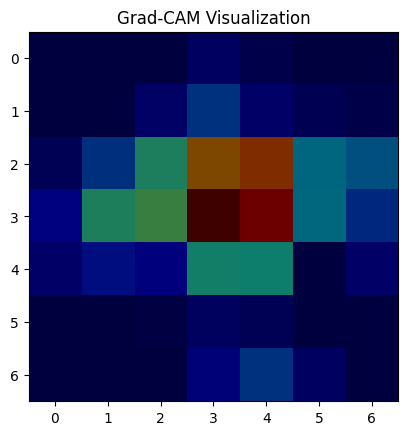

In [ ]:
# Load and preprocess the image
image_path = '/content/drive/MyDrive/Colab Notebooks/dataset/release/DeepDRiD/val/402/402_l1.jpg'
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
#input_tensor = transform(image).unsqueeze(0) # This line was causing the error.
input_tensor = transform(image).unsqueeze(0)  # Adding batch dimension here if needed

# Load your trained model
model = load_model('efficientnet_b0')  # Replace with your model loading function
model.load_state_dict(torch.load('/content/efficientnet_b0_best_model.pth'))
model.eval()

# Generate Grad-CAM
target_layer = model.features[-1]  # Adjust based on your model architecture

# Modified generate_gradcam function call to remove unnecessary unsqueeze:
cam = generate_gradcam(model, input_tensor.squeeze(0), target_layer, device='cpu')  # Adjust device as needed

# Visualize the result
plt.imshow(image)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Visualization")
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


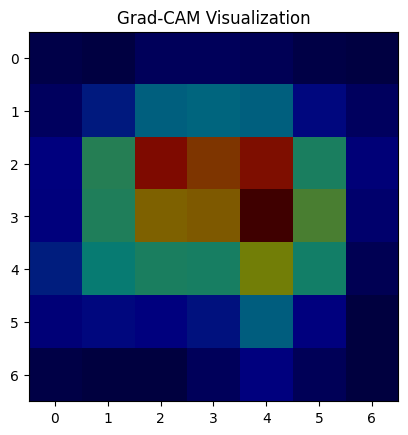

In [ ]:
# Grad-CAM Visualization Example
if __name__ == '__main__':
    example_image, _ = train_dataset[0]
    cam = generate_gradcam(model, example_image, target_layer=model.features[-1], device=device)

    plt.imshow(example_image.permute(1, 2, 0).numpy())
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Visualization")
    plt.show()

In [ ]:
import pandas as pd

# Load the file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/submission1.csv')

# Process the 'ID' column to keep only the last part of the path
df['ID'] = df['ID'].apply(lambda x: x.split('/')[-1])

# Save the updated file
df.to_csv('Resnet_finetuned_submission.csv', index=False)
